<a href="https://colab.research.google.com/github/nawaltahir/Color-Identification/blob/main/Color_Indetification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.24.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


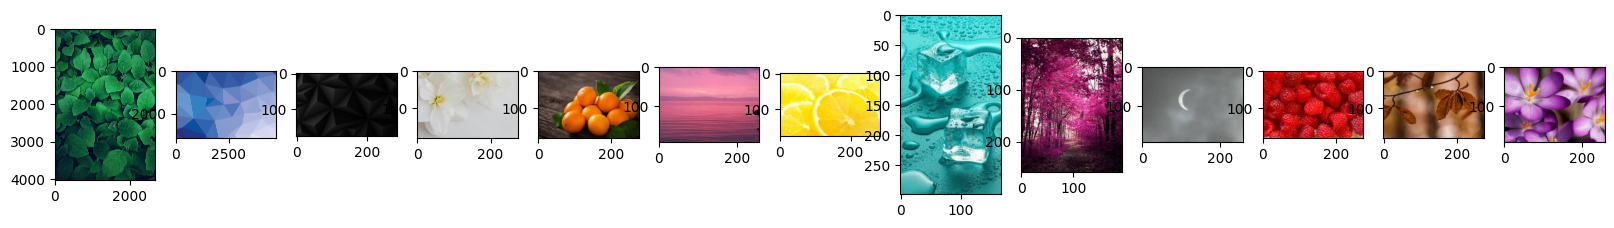

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

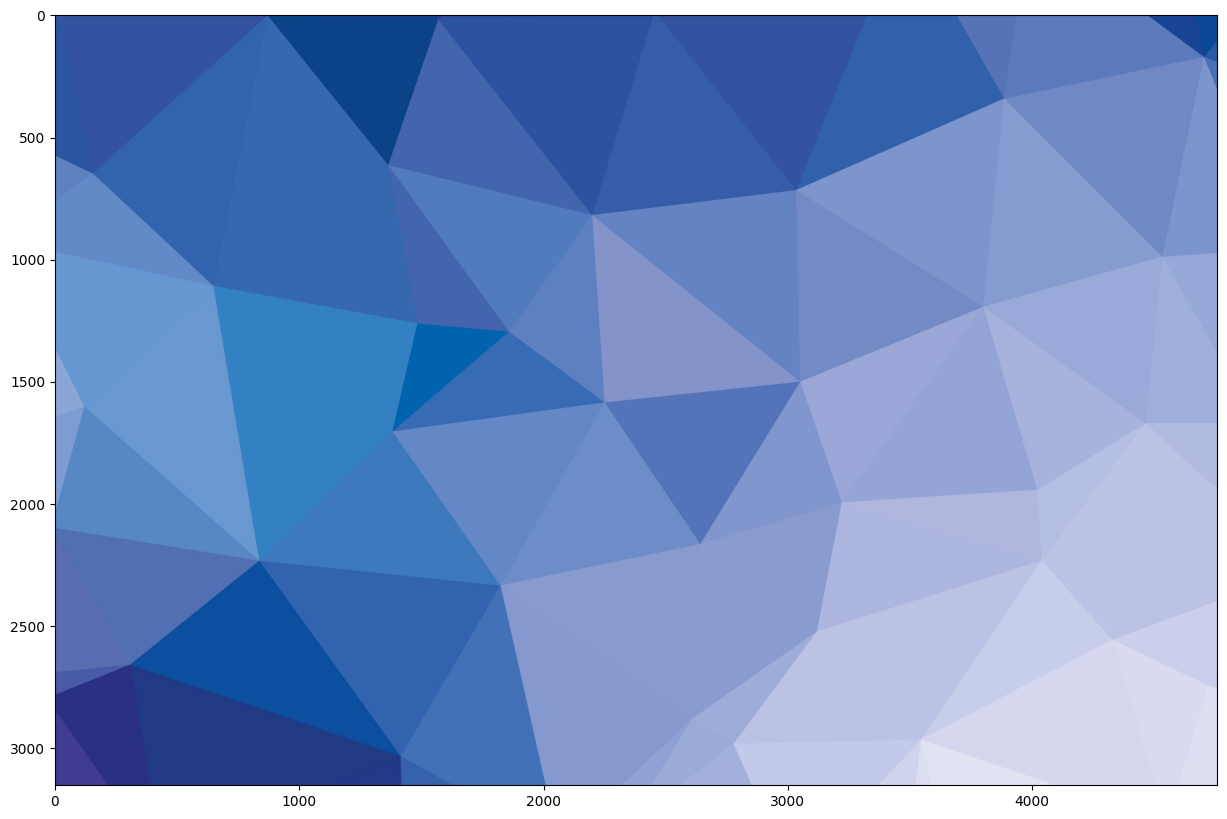

In [34]:
# Ensure all necessary packages are installed
!pip install opencv-python numpy scipy matplotlib scikit-learn scikit-image
!pip install scikit-image --upgrade
# Import required libraries
import skimage
print(skimage.__version__)
import skimage.color
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab #, deltaE_cie76
from scipy.spatial.distance import cdist
import os

# If using Google Colab, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to read and resize images
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Function to convert RGB to HEX
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

# Function to extract dominant colors using KMeans clustering
def get_colors(image, number_of_colors, show_chart=False):
    modified_image = cv2.resize(image, (600, 400), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)
    clf = KMeans(n_clusters=number_of_colors)
    labels = clf.fit_predict(modified_image)
    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if show_chart:
        plt.figure(figsize=(8, 6))
        plt.pie(counts.values(), labels=hex_colors, colors=hex_colors)
        plt.show()

    return rgb_colors

# Define image directory and color constants
IMAGE_DIRECTORY = '/content/drive/MyDrive/images'
COLORS = {
    'RED': [255, 0, 0],
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 255],
    'YELLOW': [255, 255, 0],
    'CYAN': [0, 255, 255],
    'MAGENTA':[255, 20, 147],
    'ORANGE': [255, 165, 0],
    'PINK': [255, 145, 164],
    'PURPLE': [128, 0, 128],
    'BROWN': [139, 69, 19],
    'GRAY': [128, 128, 128],
    'BLACK': [0, 0, 0],
    'WHITE': [255, 255, 255]
}
# Define threshold values for each color
THRESHOLDS = {
    'RED': 30,
    'GREEN': 30,
    'BLUE': 100,
    'YELLOW': 25,
    'CYAN': 30,
    'MAGENTA': 35,
    'ORANGE': 30,
    'PINK': 25,
    'PURPLE': 25,
    'BROWN': 30,
    'GRAY': 25,
    'BLACK': 25,
    'WHITE': 25
}
MATCH = {
    'RED': 6,
    'GREEN': 6,
    'BLUE': 2,
    'YELLOW': 1,
    'CYAN': 2,
    'MAGENTA': 10,
    'ORANGE': 3,
    'PINK': 4,
    'PURPLE': 4,
    'BROWN': 1,
    'GRAY': 1,
    'BLACK': 2,
    'WHITE': 2
}


# Load all images from the directory
images = []
if not os.path.exists(IMAGE_DIRECTORY):
    raise FileNotFoundError(f"Directory not found: {IMAGE_DIRECTORY}")
for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

# Display all loaded images
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(2, len(images), i+1)
    plt.imshow(images[i])
plt.show()

# Function to match images by color
def match_image_by_color(image, color, threshold, number_of_colors):
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        #diff = deltaE_cie94(selected_color, curr_color)
        diff = cdist(selected_color.reshape(1, -1), curr_color.reshape(1, -1), metric='euclidean')[0][0]

        #print(f"Color difference with {image_colors[i]}: {diff}")  # Debugging line

        if diff < threshold:
            select_image = True

    return select_image

# Function to display selected images
def show_selected_images(images, color_name):
    plt.figure(figsize=(20, 10))
    index = 1
    num_selected = 0  # Initialize count of selected images

    color = COLORS[color_name]
    threshold = THRESHOLDS[color_name]
    colors_to_match = MATCH[color_name]

    for i in range(len(images)):
        selected = match_image_by_color(images[i], color, threshold, colors_to_match)
        if selected:
            num_selected += 1  # Increment count if image is selected

    # Calculate rows and columns for subplots based on number of selected images
    rows = int(np.ceil(num_selected / 5))  # Adjust as needed for desired layout
    cols = min(num_selected, 5)

    for i in range(len(images)):
        selected = match_image_by_color(images[i], color, threshold, colors_to_match)
        if selected:
            plt.subplot(rows, cols, index)
            #plt.subplot(2, 5, index)
            plt.imshow(images[i])
            index += 1
    plt.show()

# Show selected images based on color criteria
#selected_color = COLORS['WHITE']  # Change this to any color you want
show_selected_images(images=images, color_name='BLUE')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


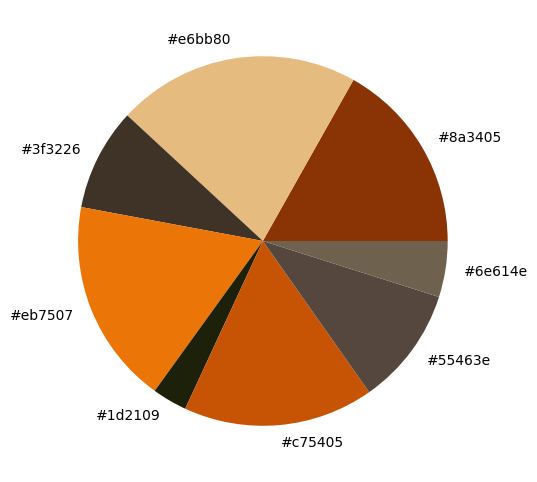

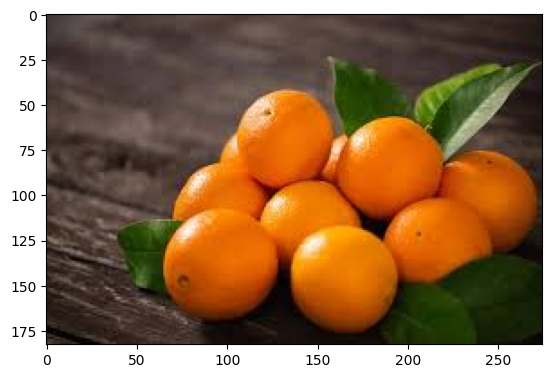

Identified RGB Colors:
[138.92167904  52.42257487   5.3694224 ]
[230.13454695 187.3740761  128.1368738 ]
[63.58118922 50.41238459 38.31993106]
[235.32019348 117.75837136   7.87271549]
[29.93511751 33.92100759  9.11051999]
[199.04435109  84.16775054   5.09710385]
[85.12447651 70.64231926 62.34149938]
[110.23045652  97.14326433  78.14849773]

Identified HEX Colors:
#8a3405
#e6bb80
#3f3226
#eb7507
#1d2109
#c75405
#55463e
#6e614e


In [48]:
# Import required libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

# If using Google Colab, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to read and resize images
def get_image(image_path):
    image = cv2.imread(image_path)
    if image is None:  # Check if image loading failed
        raise FileNotFoundError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# Function to convert RGB to HEX
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

# Function to extract dominant colors using KMeans clustering
def get_colors(image, number_of_colors, show_chart=False):
    modified_image = cv2.resize(image, (600, 400), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)
    clf = KMeans(n_clusters=number_of_colors)
    labels = clf.fit_predict(modified_image)
    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if show_chart:
        plt.figure(figsize=(8, 6))
        plt.pie(counts.values(), labels=hex_colors, colors=hex_colors)
        plt.show()

    return rgb_colors, hex_colors

# Load the image using the get_image function
image_path = '/content/drive/MyDrive/images/image 14.jpeg'  # Replace with your image path
image = get_image(image_path)

# Identify colors in the image
number_of_colors = 8  # Adjust the number of colors to extract
rgb_colors, hex_colors = get_colors(image, number_of_colors, show_chart=True)
plt.imshow(image)
plt.show()

# Print the identified colors in RGB and HEX format
print("Identified RGB Colors:")
for color in rgb_colors:
    print(color)

print("\nIdentified HEX Colors:")
for hex_color in hex_colors:
    print(hex_color)
